In [ ]:
# Mount Google Drive
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/processed_dataset /content/dataset
!cp -r /content/drive/MyDrive/processed_test.zip /content/
!cp -r /content/drive/MyDrive/val_indices.json /content/
!cp -r /content/drive/MyDrive/train_indices.json /content/

with zipfile.ZipFile("/content/processed_test.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/test")

Mounted at /content/drive


In [ ]:
train_image_dir = "/content/dataset/color"
train_mask_dir = "/content/dataset/label"
csv_path="/content/dataset/labels.csv"
test_image_dir = "/content/test/processed_test/color"
test_mask_dir="/content/test/processed_test/label"
test_csv_path="/content/test/processed_test/labels.csv"
train_json = "/content/train_indices.json"
val_json = "/content/val_indices.json"

In [ ]:
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_path):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.df = pd.read_csv(csv_path)

        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get filename and label from CSV
        row = self.df.iloc[idx]
        filename = row['filename']
        label = int(row['label'])

        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(filename)[0] + ".png")

        # Load and process image
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Load and process mask
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask, dtype=np.uint8)

        # Assign label to all foreground pixels
        mask[mask > 0] = label
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [ ]:
dataset = CatDogDataset(train_image_dir, train_mask_dir, csv_path)

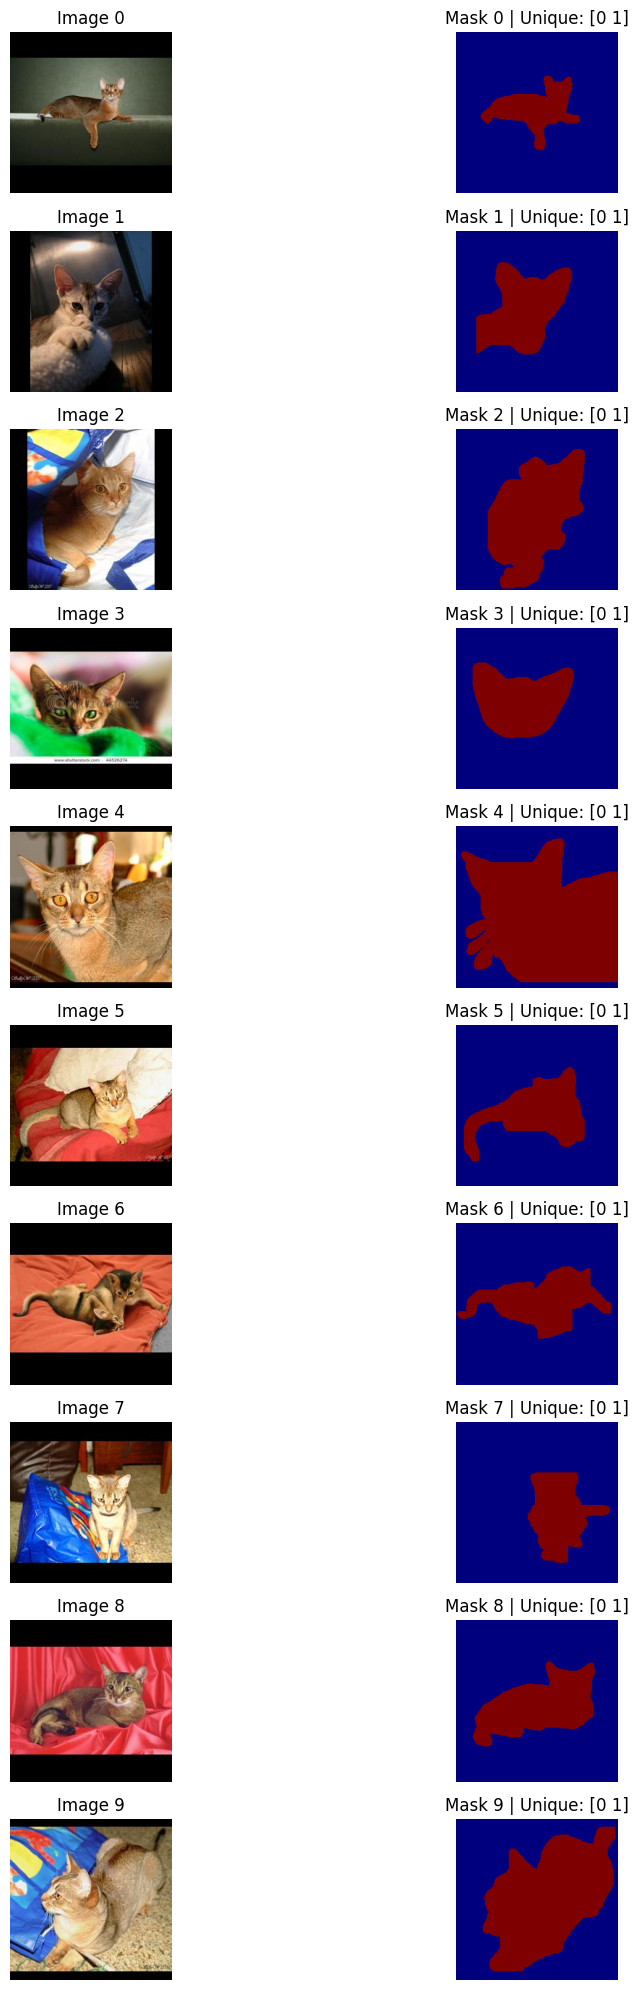

In [ ]:
import matplotlib.pyplot as plt

#print example masks to see if they function correctly
def show_samples(dataset, num_samples=10):
    plt.figure(figsize=(12, num_samples * 2))

    for i in range(num_samples):
        image, mask = dataset[i]

        # Convert tensors to numpy arrays for plotting
        image_np = image.permute(1, 2, 0).numpy()  # [H, W, C]
        mask_np = mask.numpy()

        # Show image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(image_np)
        plt.title(f"Image {i}")
        plt.axis("off")

        # Show mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(mask_np, cmap='jet')
        plt.title(f"Mask {i} | Unique: {np.unique(mask_np)}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
show_samples(dataset, num_samples=10)


In [ ]:
import torch
import torch.nn as nn

#Autoencoder model for pretraining

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Convolutional Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (112, 112)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (56, 56)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (28, 28)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # (14, 14)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),  # (7, 7)
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        # Convolutional Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # (14, 14)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (28, 28)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (56, 56)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (112, 112)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (224, 224)
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:

#Autoencoder model train and val functions
def pretrain_autoencoder(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for images, _ in loader:  # unsupervised so no need for mask/label
        images = images.to(device)

        optimizer.zero_grad()
        reconstructed = model(images)  # Image -> latent -> reconstruct

        loss = criterion(reconstructed, images)  # Compare reconstructed with original
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def validate_autoencoder(model, loader, criterion):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, _ in loader:  # No masks needed
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()

    return val_loss / len(loader)


In [ ]:
#pretrained segmenter model
class SegmentationNet(nn.Module):
    def __init__(self, encoder,num_classes=3):
        super(SegmentationNet, self).__init__()
        self.encoder = encoder  # frozen encoder

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1),  #output

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
#segmenter model train and val functions
def train_segmentation(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for images, masks in loader:
      images = images.to(device)
      masks = masks.to(device).long()  # Ensure masks are int (class labels)

      optimizer.zero_grad()
      outputs = model(images)  # Shape: (B, 3, H, W)

      loss = criterion(outputs, masks)  # CrossEntropyLoss handles softmax
      loss.backward()
      optimizer.step()

    return total_loss / len(loader)

def validate_segmentation(model, loader, criterion):
    model.eval()
    val_loss = 0
    total_pixels = 0
    correct_pixels = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).long()

            outputs = model(images)  # Shape: (B, 3, H, W)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)  # (B, H, W)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

    accuracy = correct_pixels / total_pixels
    return val_loss / len(loader), accuracy


In [ ]:
import json

# Reload dataset
dataset = CatDogDataset(train_image_dir, train_mask_dir, csv_path)

# Load indices from files to keep constant train/val split
with open("train_indices.json", "r") as f:
    train_indices = json.load(f)

with open("val_indices.json", "r") as f:
    val_indices = json.load(f)

# Recreate the subsets
# Create subsets
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

# Wrap in DataLoader
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

In [ ]:
#Pretrain Autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder().to(device)
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion_ae = nn.MSELoss()
scheduler_ae = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ae, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')

pretrain_epochs=15
seg_epochs=15

for epoch in range(pretrain_epochs):
    train_loss = pretrain_autoencoder(autoencoder, train_loader, criterion_ae, optimizer_ae)
    val_loss = validate_autoencoder(autoencoder, val_loader, criterion_ae)

    print(f"[Autoencoder] Epoch {epoch+1}/{pretrain_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(autoencoder.state_dict(), "best_ae.pth")
        print("Best autoencoder model saved!")

    scheduler_ae.step(val_loss)

# Load Best Autoencoder and Freeze Encoder
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load("best_ae.pth"))
autoencoder.eval()

frozen_encoder = autoencoder.encoder

# Freeze encoder weights
for param in frozen_encoder.parameters():
    param.requires_grad = False


segmenter = SegmentationNet(frozen_encoder).to(device)
optimizer_seg = torch.optim.Adam(filter(lambda p: p.requires_grad, segmenter.parameters()), lr=1e-4)
criterion_seg = nn.CrossEntropyLoss(weight=torch.tensor([0.8, 1.5, 1.2], device=device))
scheduler_seg = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_seg, mode='min', factor=0.5, patience=5)

best_val_loss = float('inf')  # Reset for segmentation

#Train Segmentation Model
for epoch in range(seg_epochs):
    train_loss = train_segmentation(segmenter, train_loader, criterion_seg, optimizer_seg)
    val_loss, val_acc = validate_segmentation(segmenter, val_loader, criterion_seg)

    print(f"[Segmentation] Epoch {epoch+1}/{seg_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(segmenter.state_dict(), "best_seg.pth")
        print("Best segmentation model saved!")

    scheduler_seg.step(val_loss)



[Autoencoder] Epoch 1/15 - Train Loss: 0.0768, Val Loss: 0.0254
Best autoencoder model saved!
[Autoencoder] Epoch 2/15 - Train Loss: 0.0179, Val Loss: 0.0124
Best autoencoder model saved!
[Autoencoder] Epoch 3/15 - Train Loss: 0.0124, Val Loss: 0.0097
Best autoencoder model saved!
[Autoencoder] Epoch 4/15 - Train Loss: 0.0120, Val Loss: 0.0113
[Autoencoder] Epoch 5/15 - Train Loss: 0.0104, Val Loss: 0.0084
Best autoencoder model saved!
[Autoencoder] Epoch 6/15 - Train Loss: 0.0093, Val Loss: 0.0069
Best autoencoder model saved!
[Autoencoder] Epoch 7/15 - Train Loss: 0.0073, Val Loss: 0.0061
Best autoencoder model saved!
[Autoencoder] Epoch 8/15 - Train Loss: 0.0068, Val Loss: 0.0051
Best autoencoder model saved!
[Autoencoder] Epoch 9/15 - Train Loss: 0.0064, Val Loss: 0.0052
[Autoencoder] Epoch 10/15 - Train Loss: 0.0059, Val Loss: 0.0049
Best autoencoder model saved!
[Autoencoder] Epoch 11/15 - Train Loss: 0.0056, Val Loss: 0.0054
[Autoencoder] Epoch 12/15 - Train Loss: 0.0053, Val Lo

In [ ]:
import torch
Best_seg= SegmentationNet(frozen_encoder).to(device)
Best_seg.load_state_dict(torch.load("best_seg.pth"))

# Set the path to save in Google Drive
model_save_path = "/content/drive/MyDrive/best_segmenter.pth"

# Save the segmenter's state dict
torch.save(Best_seg.state_dict(), model_save_path)

print(f"Best segmentation model saved to: {model_save_path}")


Best segmentation model saved to: /content/drive/MyDrive/best_segmenter.pth


Unique classes in predicted mask: [0 1 2]
Unique classes in real mask: [0 1]


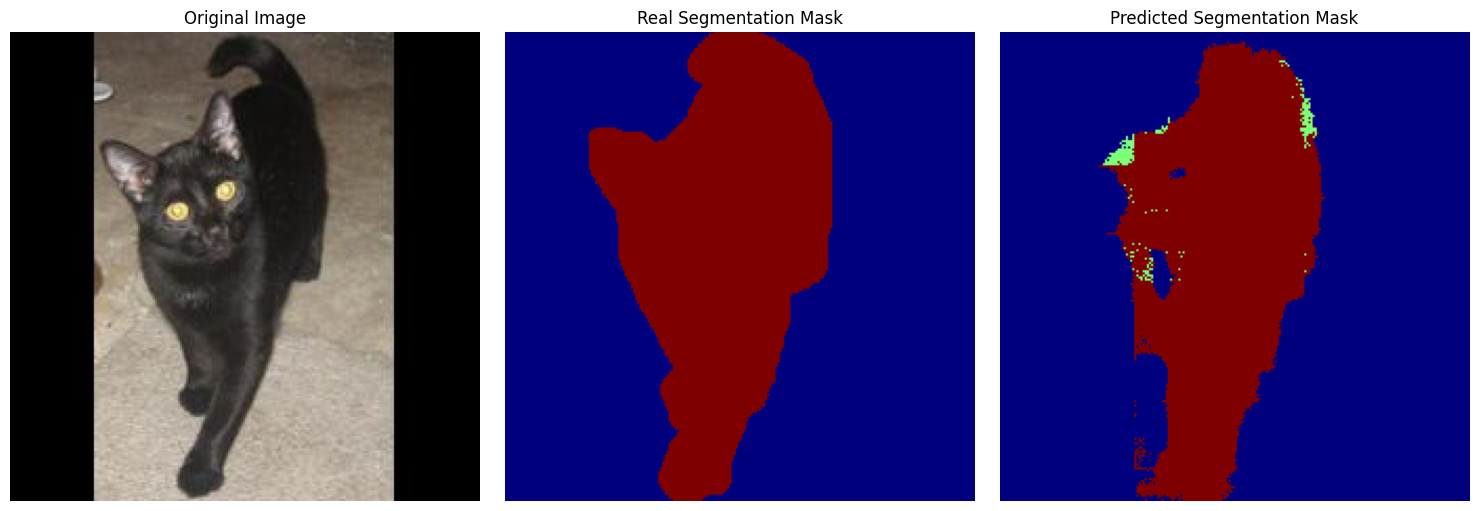

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import random

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationNet(frozen_encoder).to(device)
model.load_state_dict(torch.load("best_seg.pth", map_location=device))
model.eval()

# Get one batch from the val_loader
val_iter = iter(val_loader)
images, masks = next(val_iter)


# Select one image and mask
image = images[0].to(device)
real_mask = masks[0]

# Add batch dimension
input_tensor = image.unsqueeze(0)

# Forward pass
with torch.no_grad():
    output = model(input_tensor)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# Real mask to numpy
real_mask_np = real_mask.cpu().numpy()

# Print unique class values
print("Unique classes in predicted mask:", np.unique(predicted_mask))
print("Unique classes in real mask:", np.unique(real_mask_np))

# Convert image for display (to PIL image)
image_disp = to_pil_image(image.cpu())

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image_disp)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(real_mask_np, cmap="jet")
ax[1].set_title("Real Segmentation Mask")
ax[1].axis("off")

ax[2].imshow(predicted_mask, cmap="jet")
ax[2].set_title("Predicted Segmentation Mask")
ax[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch

def iou_per_class(y_true, y_pred, num_classes):
    iou_scores = []
    for cls in range(num_classes):
        intersection = torch.logical_and(y_true == cls, y_pred == cls).float().sum()
        union = torch.logical_or(y_true == cls, y_pred == cls).float().sum()
        iou_scores.append((intersection / union).item() if union > 0 else 0.0)
    return iou_scores  # List of IoU scores for each class

def dice_per_class(y_true, y_pred, num_classes):
    dice_scores = []
    for cls in range(num_classes):
        intersection = torch.logical_and(y_true == cls, y_pred == cls).float().sum()
        denominator = (y_true.eq(cls).float().sum() + y_pred.eq(cls).float().sum())
        dice_scores.append((2.0 * intersection / denominator).item() if denominator > 0 else 0.0)
    return dice_scores  # List of Dice scores for each class

def pixel_accuracy_per_class(y_true, y_pred, num_classes):
    acc_scores = []
    for cls in range(num_classes):
        mask_cls = (y_true == cls)
        acc_scores.append((y_pred[mask_cls] == cls).float().mean().item() if mask_cls.sum() > 0 else 0.0)
    return acc_scores  # List of Accuracy scores for each class


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def evaluate_model_per_class(model, test_loader, num_classes, device="cuda"):
    model.eval()
    iou_scores_per_class = [[] for _ in range(num_classes)]
    dice_scores_per_class = [[] for _ in range(num_classes)]
    accuracy_scores_per_class = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convert to class labels

            for i in range(len(images)):
                iou_scores = iou_per_class(masks[i], preds[i], num_classes)
                dice_scores = dice_per_class(masks[i], preds[i], num_classes)
                acc_scores = pixel_accuracy_per_class(masks[i], preds[i], num_classes)

                for cls in range(num_classes):
                    iou_scores_per_class[cls].append(iou_scores[cls])
                    dice_scores_per_class[cls].append(dice_scores[cls])
                    accuracy_scores_per_class[cls].append(acc_scores[cls])

    # Compute mean per-class metrics (handle empty lists)
    mean_iou_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in iou_scores_per_class]
    mean_dice_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in dice_scores_per_class]
    mean_accuracy_per_class = [torch.mean(torch.tensor(scores)).item() if scores else 0.0 for scores in accuracy_scores_per_class]

    # Compute overall mean (average over classes)
    mean_iou = sum(mean_iou_per_class) / num_classes
    mean_dice = sum(mean_dice_per_class) / num_classes
    mean_accuracy = sum(mean_accuracy_per_class) / num_classes

    print(f"Mean IoU Per Class: {mean_iou_per_class}")
    print(f"Mean Dice Per Class: {mean_dice_per_class}")
    print(f"Mean Accuracy Per Class: {mean_accuracy_per_class}")
    print(f"Overall Mean IoU: {mean_iou:.4f} (Baseline: 0.33)")
    print(f"Overall Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Overall Mean Pixel Accuracy: {mean_accuracy:.4f}")

    return mean_iou_per_class, mean_dice_per_class, mean_accuracy_per_class, mean_iou, mean_dice, mean_accuracy


In [ ]:
#test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
num_classes = 3  # Change this based on your dataset

Test_Set = CatDogDataset(test_image_dir, test_mask_dir, test_csv_path)
Test_loader = DataLoader(Test_Set, batch_size=8, shuffle=False)
evaluate_model_per_class(model,Test_loader, num_classes)

Mean IoU Per Class: [0.81539386510849, 0.10680923610925674, 0.35122305154800415]
Mean Dice Per Class: [0.8947764039039612, 0.15250591933727264, 0.44904330372810364]
Mean Accuracy Per Class: [0.8956417441368103, 0.12017177045345306, 0.4232197105884552]
Overall Mean IoU: 0.4245 (Baseline: 0.33)
Overall Mean Dice Coefficient: 0.4988
Overall Mean Pixel Accuracy: 0.4797


([0.81539386510849, 0.10680923610925674, 0.35122305154800415],
 [0.8947764039039612, 0.15250591933727264, 0.44904330372810364],
 [0.8956417441368103, 0.12017177045345306, 0.4232197105884552],
 0.4244753842552503,
 0.4987752089897792,
 0.4796777417262395)